# Econ 281: Computational Tools in Macroeconomics

### Homework 4: Idiosyncratic Risk

##### Youngdoo Choi (yoc005@ucsd.edu), April 2024

---

### 0. Classroom exercise

- Solve HJB with idiosyncratic risks using implicit method

- Compute stationary distribution using KFE

In [1]:
# Import packages
import numpy as np
import matplotlib.pyplot as plt
import scipy.sparse as sp
import time

### Parameterization

In [2]:
# Set structural parameters
class Parameters:
    def __init__(self):
        # self.beta = 0.99
        # self.rho = -np.log(self.beta)
        # self.r = self.rho
        self.rho = 0.05
        self.r = 0.035
        self.y = np.array((0.1, 0.2))
        self.lambda_vec = np.array((0.5, 0.5))

params = Parameters()

In [3]:
# Set numerical parameters
class Num_parameters:
    def __init__(self):
        self.amin = -0.02
        self.amax = 3.0
        self.agridsize = 100
        self.agrid = np.linspace(self.amin, self.amax, self.agridsize)
        self.gridstep = self.agrid[1] - self.agrid[0]
        self.Delta = 0.5
        self.max_iter = 1000
        self.tol = 1e-6

num_params = Num_parameters()

In [4]:
# Define utility functions
def utility(c):
    return np.log(c)

def marginal_utility(c):
    return 1/c

def inv_marginal_utility(x):
    return 1/x

### Solve HJB

In [5]:
# Define a function for upwind scheme
def Upwind_scheme(V_old, params, num_params):

    V_diff = (V_old[1:] - V_old[:-1]) / num_params.gridstep

    # Compute using forward differences
    forward_boundary = np.zeros((1, V_diff.shape[1]))
    Vp_forward = np.vstack((V_diff, forward_boundary))
    c_forward = inv_marginal_utility(np.maximum(1e-8, Vp_forward))
    drift_forward = params.r * num_params.agrid[:, None] + params.y - c_forward

    # Compute using backward difference
    backward_boundary = np.array((inv_marginal_utility(params.r*num_params.agrid[0] + params.y[0]), inv_marginal_utility(params.r*num_params.agrid[0] + params.y[1])))
    Vp_backward = np.vstack((backward_boundary, V_diff))
    c_backward = inv_marginal_utility(np.maximum(1e-8, Vp_backward))
    drift_backward = params.r * num_params.agrid[:, None] + params.y - c_backward

    # Compute Vp at steady states
    Vp_bar = marginal_utility(params.r * num_params.agrid[:, None] + params.y)

    # Compute consumption
    Vprime = Vp_forward * (drift_forward > 0) + Vp_backward * (drift_backward < 0) + Vp_bar * (1-(drift_forward > 0)-(drift_backward < 0))
    consumption = inv_marginal_utility(Vprime)

    # Compute the A matrix
    A_switch = np.block([[-params.lambda_vec[0]*np.eye(num_params.agridsize), params.lambda_vec[0]*np.eye(num_params.agridsize)], 
                         [params.lambda_vec[1]*np.eye(num_params.agridsize), -params.lambda_vec[1]*np.eye(num_params.agridsize)]])

    diagonal_main = (np.minimum(drift_backward[:], 0) - np.maximum(drift_forward[:], 0)) / num_params.gridstep
    diagonal_upper = np.maximum(drift_forward[:-1], 0) / num_params.gridstep
    diagonal_lower = -np.minimum(drift_backward[1:], 0) / num_params.gridstep
    A_mat1 = np.diag(diagonal_main[:, 0]) + np.diag(diagonal_upper[:, 0], k=1) + np.diag(diagonal_lower[:, 0], k=-1)
    A_mat2 = np.diag(diagonal_main[:, 1]) + np.diag(diagonal_upper[:, 1], k=1) + np.diag(diagonal_lower[:, 1], k=-1)

    A_mat = np.block([[A_mat1, np.zeros((num_params.agridsize, num_params.agridsize))], 
                      [np.zeros((num_params.agridsize, num_params.agridsize)), A_mat2]])
    A_mat = A_mat + A_switch

    return A_mat, consumption

In [6]:
# Define a function to update value functions
def HJB_Operator(V_old, params, num_params):

    # Implement upwind scheme
    A_mat, consumption = Upwind_scheme(V_old, params, num_params)
    saving = (1+params.r)*num_params.agrid[:, None] + params.y - consumption
    
    # Update the value function
    A_mat_sparse = sp.csr_matrix(A_mat)
    coef_mat = (params.rho + 1/num_params.Delta) * sp.eye(2*num_params.agridsize) - A_mat_sparse
    consumption_vec = consumption.T.reshape(-1)
    V_old_vec = V_old.T.reshape(-1)
    rhs = utility(consumption_vec) + 1/num_params.Delta * V_old_vec
    V_new = sp.linalg.spsolve(coef_mat, rhs)
    V_new = np.vstack([V_new[0:100], V_new[100:]]).T

    return V_new, consumption, saving, A_mat

In [7]:
# Define a function to converge value functions
def HJB_Iteration(V_0, params, num_params, progress=True, prog_freq=100):

    start_time = time.time()
    V_old = V_0

    # Iterate the HJB operator until convergence
    for iter in range(num_params.max_iter):
        V_new, consumption, saving, A_mat = HJB_Operator(V_old, params, num_params)

        error = np.max(np.abs(V_new - V_old))
        if error < num_params.tol:
            print(f"HJB_Iteration done: {iter} iter, {time.time() - start_time:.2f} seconds")
            return V_new, consumption, saving, A_mat
        else:
            V_old = V_new

        if progress == True and iter % prog_freq == 0:
            print(f"HJB_Iteration in progress: iter {iter}, error {error}")

    if iter == num_params.max_iter - 1:
        print("HJB_Iteration Error: No convergence")

In [8]:
# Solve
V_0 = np.linspace(0, 1, num_params.agridsize)
V_0 = np.column_stack((V_0, V_0))
V_star, consumption, saving, A_mat = HJB_Iteration(V_0, params, num_params)

HJB_Iteration in progress: iter 0, error 1.0709279138113987
HJB_Iteration in progress: iter 100, error 0.07918957348424271
HJB_Iteration in progress: iter 200, error 0.006702695094517708
HJB_Iteration in progress: iter 300, error 0.0005673653112339139
HJB_Iteration in progress: iter 400, error 4.8025980447619077e-05
HJB_Iteration in progress: iter 500, error 4.065272868558623e-06
HJB_Iteration done: 557 iter, 0.41 seconds


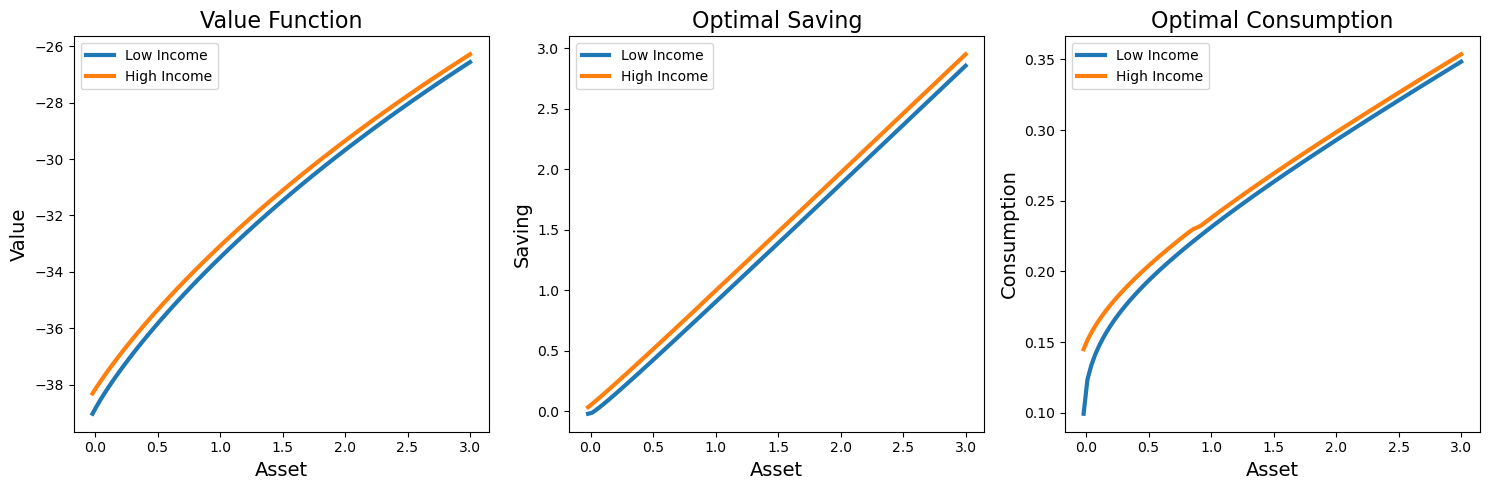

In [9]:
# Plot the graph
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

axs[0].plot(num_params.agrid, V_star[:, 0], label='Low Income', linewidth=3)
axs[0].plot(num_params.agrid, V_star[:, 1], label='High Income', linewidth=3)
axs[0].set_xlabel('Asset', fontsize=14)
axs[0].set_ylabel('Value', fontsize=14)
axs[0].set_title('Value Function', fontsize=16)
axs[0].legend()

axs[1].plot(num_params.agrid, saving[:, 0], label='Low Income', linewidth=3)
axs[1].plot(num_params.agrid, saving[:, 1], label='High Income', linewidth=3)
axs[1].set_xlabel('Asset', fontsize=14)
axs[1].set_ylabel('Saving', fontsize=14)
axs[1].set_title('Optimal Saving', fontsize=16)
axs[1].legend()

axs[2].plot(num_params.agrid, consumption[:, 0], label='Low Income', linewidth=3)
axs[2].plot(num_params.agrid, consumption[:, 1], label='High Income', linewidth=3)
axs[2].set_xlabel('Asset', fontsize=14)
axs[2].set_ylabel('Consumption', fontsize=14)
axs[2].set_title('Optimal Consumption', fontsize=16)
axs[2].legend()

plt.tight_layout()
plt.show()

### Compute stationary distribution

In [10]:
# Define a function to compute stationary equilibrium
def KFE_Distribution(A_mat, num_params):

    # Assign a positive value to avoid singularity
    b = np.zeros((2*num_params.agridsize, 1))
    b[0] = 0.1

    # Modify corresponding row of A' matrix
    row = np.zeros((1, 2*num_params.agridsize))
    row[0][0] = 1
    A_transpose = np.transpose(A_mat)
    A_transpose[0, :] = row
    A_transpose = sp.csr_matrix(np.transpose(A_mat))

    # Compute the solution
    g = sp.linalg.spsolve(A_transpose, b)
    g_sum = np.dot(g, np.ones(2*num_params.agridsize)) * num_params.gridstep
    g = g/g_sum # normalize
    g = np.vstack([g[0:100], g[100:]]).T
    return g

In [11]:
# Solve
g = KFE_Distribution(A_mat, num_params)

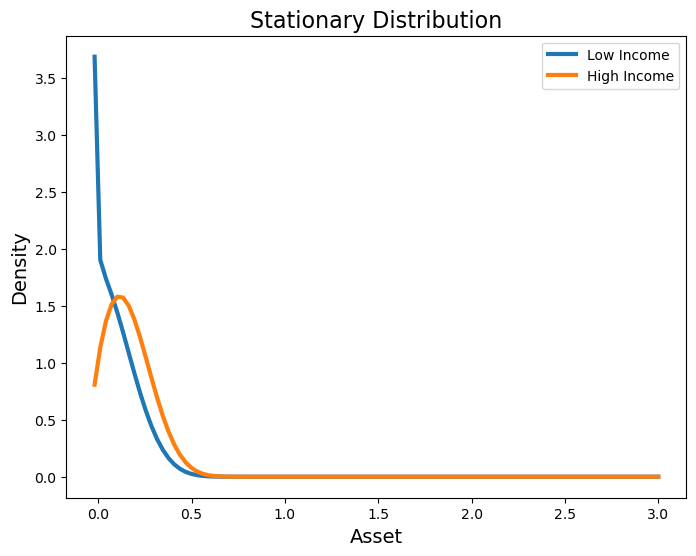

In [12]:
# Plot the graph
plt.figure(figsize=(8, 6))
plt.plot(num_params.agrid, g[:, 0], label='Low Income', linewidth=3)
plt.plot(num_params.agrid, g[:, 1], label='High Income', linewidth=3)
plt.xlabel('Asset', fontsize=14)
plt.ylabel('Density', fontsize=14)
plt.title('Stationary Distribution', fontsize=16)
plt.legend()
plt.show()

---

### 1. Indirect inference

- Calibrate parameters

### Umemployment spell

The average length of unemployment = $\int_0^{\infty} t (1-\lambda_L)^t \lambda_L dt \approx \sum_{t=1}^\infty t (1-\lambda_L)^{t-1} \lambda_L$ where one time period is a quarter here ($\because$ given $\rho$ value).

\begin{align*}
    \sum_{t=1}^\infty t (1-\lambda_L)^{t-1} \lambda_L &= \frac{\lambda_L}{1-\lambda_L} \left[ (1-\lambda_L) \sum_{t=0}^\infty t (1-\lambda_L)^t + \frac{1-\lambda_L}{\lambda_L} \right] \\
    &= \frac{1}{\lambda_L}
\end{align*}

Therefore, $\lambda_L$ should be $\frac{1}{2}$ (one quarter of average unemployment duration).

### Aggregate saving

In [13]:
# Define a function to compute aggregate saving for given interest rate
def Compute_saving(interest_rate, params, num_params):

    params.r = interest_rate

    # Solve HJB
    V_0 = np.linspace(0, 1, num_params.agridsize)
    V_0 = np.column_stack((V_0, V_0))
    _, _, saving, A_mat = HJB_Iteration(V_0, params, num_params, progress=False)

    # Solve KFE
    g = KFE_Distribution(A_mat, num_params)

    # Compute aggregate saving
    aggregate_saving = np.sum(saving * g * num_params.gridstep)
    return aggregate_saving

In [14]:
r_vectors = np.arange(0, 0.041, 0.001)
aggregate_savings = np.empty(r_vectors.size)
for idx, interest_rate in enumerate(r_vectors):
    aggregate_saving = Compute_saving(interest_rate, params, num_params)
    aggregate_savings[idx] = aggregate_saving

HJB_Iteration done: 558 iter, 0.40 seconds
HJB_Iteration done: 558 iter, 0.35 seconds
HJB_Iteration done: 558 iter, 0.35 seconds
HJB_Iteration done: 558 iter, 0.35 seconds
HJB_Iteration done: 558 iter, 0.35 seconds
HJB_Iteration done: 558 iter, 0.34 seconds
HJB_Iteration done: 558 iter, 0.35 seconds
HJB_Iteration done: 558 iter, 0.35 seconds
HJB_Iteration done: 558 iter, 0.35 seconds
HJB_Iteration done: 558 iter, 0.34 seconds
HJB_Iteration done: 558 iter, 0.34 seconds
HJB_Iteration done: 558 iter, 0.34 seconds
HJB_Iteration done: 558 iter, 0.34 seconds
HJB_Iteration done: 558 iter, 0.34 seconds
HJB_Iteration done: 558 iter, 0.35 seconds
HJB_Iteration done: 558 iter, 0.35 seconds
HJB_Iteration done: 558 iter, 0.35 seconds
HJB_Iteration done: 558 iter, 0.35 seconds
HJB_Iteration done: 558 iter, 0.35 seconds
HJB_Iteration done: 558 iter, 0.35 seconds
HJB_Iteration done: 558 iter, 0.35 seconds
HJB_Iteration done: 558 iter, 0.35 seconds
HJB_Iteration done: 558 iter, 0.35 seconds
HJB_Iterati

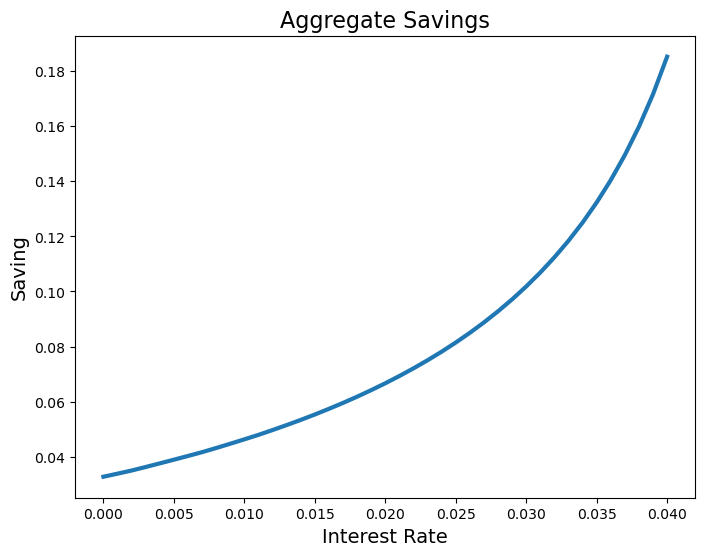

In [15]:
# Plot the graph
plt.figure(figsize=(8, 6))
plt.plot(r_vectors, aggregate_savings, linewidth=3)
plt.xlabel('Interest Rate', fontsize=14)
plt.ylabel('Saving', fontsize=14)
plt.title('Aggregate Savings', fontsize=16)
plt.show()